# Forecasting Stock Returns with Liquid Neural Networks

### 1. Environment set-up

1. This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to the [Time Series Forecasting (CfC) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-7s4giphluwgta).

To subscribe to the algorithm:
1. Open the algorithm listing page.
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on the **Continue to configuration** button and then choose a **region**, you will see a **Product ARN**. This is the algorithm ARN that you need to specify while training a custom ML model. **Copy the ARN corresponding to your region and specify the same in the following cell.**

In [1]:
algo_arn = "arn:aws:sagemaker:<...>"

Install the [Yahoo! Finance Python API](https://github.com/ranaroussi/yfinance).

In [2]:
!pip install yfinance 

Set up the SageMaker session.

In [3]:
import io
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, accuracy_score, f1_score

# SageMaker session
sagemaker_session = sagemaker.Session()

# SageMaker role
role = sagemaker.get_execution_role()

# S3 bucket
bucket = sagemaker_session.default_bucket()

# EC2 instance
instance_type = "ml.m5.4xlarge"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Define the sequence lengths.

In [4]:
context_length = 30

In [5]:
prediction_length = 30

### 2. Data preparation

Download the data.

In [6]:
tickers = ["^SPX", "^VIX", "^VVIX", "^VXN", "^GVZ", "^OVX"]
dataset = yf.download(" ".join(tickers), start="2022-06-30", end="2024-06-29")

[*********************100%%**********************]  6 of 6 completed


Extract the close prices.

In [7]:
dataset = dataset.loc[:, dataset.columns.get_level_values(0) == "Close"]
dataset.columns = dataset.columns.get_level_values(1)

Forward fill the missing values.

In [8]:
dataset.ffill(inplace=True)

In [9]:
dataset.shape

(502, 6)

In [10]:
dataset.head()

Ticker,^GVZ,^OVX,^SPX,^VIX,^VVIX,^VXN
Date,,,,,,
2022-06-30,19.610001,48.900002,3785.379883,28.709999,89.389999,36.209999
2022-07-01,20.170000,49.400002,3825.330078,26.700001,85.510002,34.270000
2022-07-05,21.330000,52.610001,3831.389893,27.540001,87.300003,34.860001
2022-07-06,21.910000,54.669998,3845.080078,26.730000,85.879997,33.750000
2022-07-07,20.500000,52.869999,3902.620117,26.080000,85.879997,32.810001


In [11]:
dataset.tail()

Ticker,^GVZ,^OVX,^SPX,^VIX,^VVIX,^VXN
Date,,,,,,
2024-06-24,15.49,25.420000,5447.870117,13.33,84.800003,17.240000
2024-06-25,14.88,25.750000,5469.299805,12.84,82.870003,16.700001
2024-06-26,14.88,26.240000,5477.899902,12.55,81.449997,16.500000
2024-06-27,15.01,26.280001,5482.870117,12.24,79.500000,16.290001
2024-06-28,14.72,26.540001,5460.479980,12.44,79.480003,16.240000


Calculate the returns.

In [12]:
dataset["Return30"] = np.log(dataset["^SPX"]).diff(periods=30)

Calculate the realized volatility.

In [13]:
dataset["RVOL"] = np.log(dataset["^SPX"]).diff(periods=1).rolling(window=30).std(ddof=1)

Drop the prices.

In [14]:
dataset.drop(labels=["^SPX"], axis=1, inplace=True)

Drop the missing values.

In [15]:
dataset.dropna(inplace=True)

Move the returns to the first columns.

In [16]:
dataset = dataset[["Return30"] + dataset.columns.drop("Return30").tolist()]

Visualize the data.

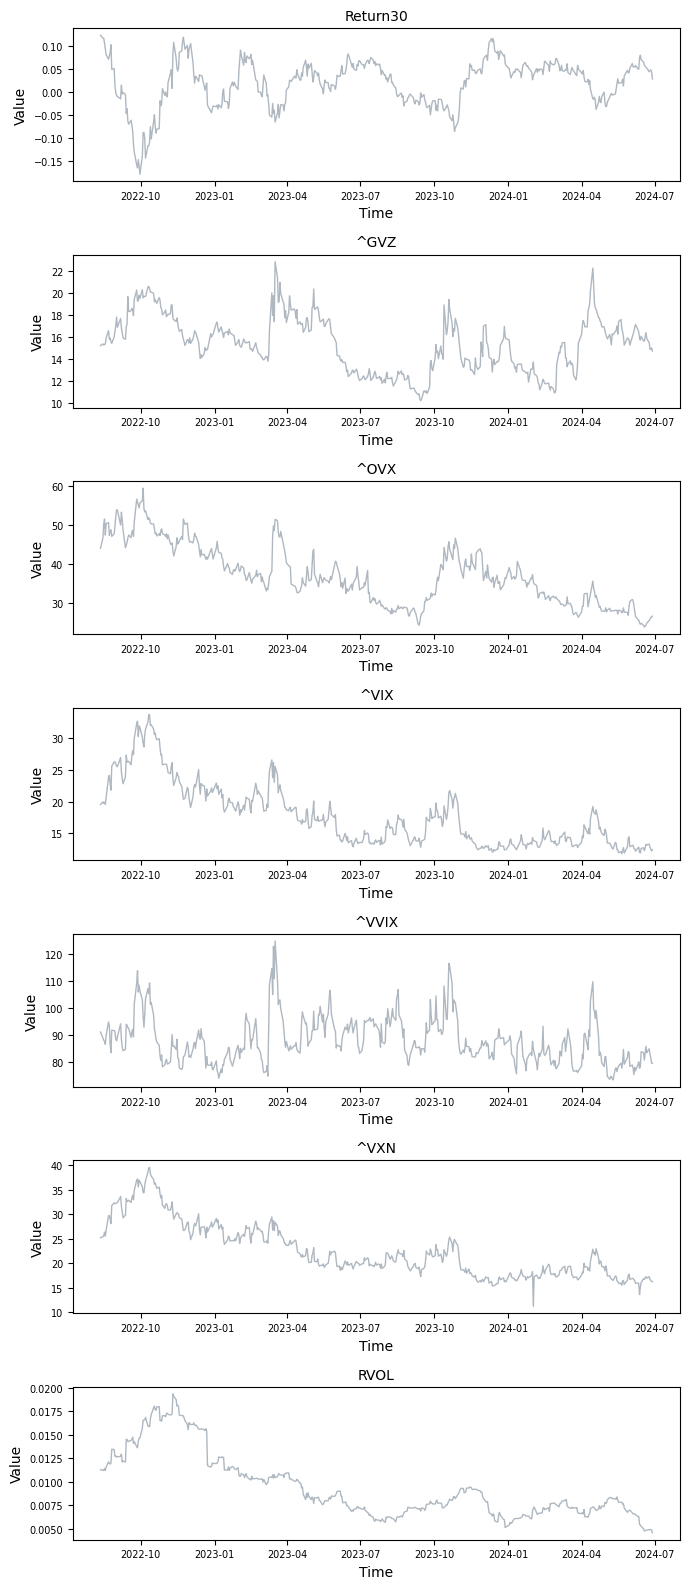

In [17]:
fig, axs = plt.subplots(nrows=dataset.shape[1], ncols=1, sharex=True, figsize=(7, 16))
for i in range(dataset.shape[1]):
    axs[i].plot(dataset.iloc[:, i], color="#AFB8C1", lw=1)
    axs[i].set_title(f"{dataset.columns[i]}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.tight_layout()
fig.show()

Rename the columns.

In [18]:
dataset.columns = ["y"] + [f"x{i}" for i in range(dataset.shape[1] - 1)]

Split the data.

In [19]:
test_size = int(0.3 * len(dataset))

In [20]:
training_dataset = dataset.iloc[:- test_size - context_length - prediction_length - 1]

In [21]:
training_dataset.shape

(270, 7)

In [22]:
print(training_dataset.index.min())
print(training_dataset.index.max())

2022-08-12 00:00:00
2023-09-08 00:00:00


In [23]:
test_dataset = dataset.iloc[- test_size - context_length - prediction_length - 1:]

In [24]:
test_dataset.shape

(202, 7)

In [25]:
print(test_dataset.index.min())
print(test_dataset.index.max())

2023-09-11 00:00:00
2024-06-28 00:00:00


### 3. Training

Upload the training data to S3.

In [26]:
training_data = sagemaker_session.upload_string_as_file_body(
    body=training_dataset.to_csv(index=False),
    bucket=bucket,
    key="training_dataset.csv"
)

Train the model.

In [27]:
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        "context-length": context_length,
        "prediction-length": prediction_length,
        "sequence-stride": 1,
        "hidden-size": 20,
        "backbone-layers": 1,
        "backbone-units": 40,
        "backbone-activation": "lecun",
        "backbone-dropout": 0,
        "minimal": True,
        "no-gate": True,
        "use-mixed": False,
        "use-ltc": False,
        "batch-size": 32,
        "lr": 0.0001,
        "lr-decay": 0.9999,
        "epochs": 800,
    }
)

estimator.fit({"training": training_data})

INFO:sagemaker:Creating training-job with name: cfc-tsf-v1-6-2024-06-29-19-33-07-178


2024-06-29 19:33:07 Starting - Starting the training job...
2024-06-29 19:33:25 Starting - Preparing the instances for training...
2024-06-29 19:34:04 Downloading - Downloading the training image...............
2024-06-29 19:36:29 Training - Training image download completed. Training in progress......bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-06-29 19:37:18,544 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-06-29 19:37:18,545 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-06-29 19:37:18,545 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-06-29 19:37:18,545 sagemaker-training-toolkit INFO     Failed to parse hyperparameter backbone-activation value lecun to Json.
Returning the value itself
2024-06-29 19:37:18,556 sagemaker_pytorch_container.training INFO     Block until all host

### 4. Inference

Deploy the model.

In [28]:
serializer = sagemaker.serializers.CSVSerializer(content_type="text/csv")
deserializer = sagemaker.base_deserializers.PandasDeserializer(accept="text/csv")

In [29]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
)

INFO:sagemaker:Creating model package with name: cfc-tsf-v1-6-2024-06-29-19-39-21-270


.........

INFO:sagemaker:Creating model with name: cfc-tsf-v1-6-2024-06-29-19-39-21-270


INFO:sagemaker:Creating endpoint-config with name cfc-tsf-v1-6-2024-06-29-19-39-21-270
INFO:sagemaker:Creating endpoint with name cfc-tsf-v1-6-2024-06-29-19-39-21-270


----------!

Define a function for generating the predictions.

In [30]:
def get_predictions(data):
    # create a list for storing the predictions
    predictions = []

    # loop across the dates
    for t in range(context_length, len(data) - prediction_length + 1):

        # extract the data up to day t - 1
        payload = data.iloc[t - context_length: t]

        # predict all rolling 30-day returns from day t to day t + 30
        response = sagemaker_session.sagemaker_runtime_client.invoke_endpoint(
            EndpointName=predictor.endpoint_name,
            ContentType="text/csv",
            Body=payload.to_csv(index=False)
        )
        response = deserializer.deserialize(response["Body"], content_type="text/csv")

        # extract the predicted 30-day return from day t to day t + 30
        prediction = response.iloc[-1:]

        # extract the date corresponding to day t + 30
        prediction.index = [data.index[t + prediction_length - 1]]

        # save the prediction
        predictions.append(prediction)

    # cast the predictions to data frame
    predictions = pd.concat(predictions)

    # add the actual values
    predictions["y"] = data["y"]

    return predictions

Define a function for visualizing the predictions.

In [31]:
def plot_predictions(predictions):
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(predictions.index, predictions["y"].values, color="#7f8ea3", lw=1, label="Actual")
    ax.plot(predictions.index, predictions["y_mean"].values, color="#009ad3", lw=1, label="Predicted")
    ax.fill_between(predictions.index, predictions["y_mean"].values + predictions["y_std"].values, predictions["y_mean"].values - predictions["y_std"].values, color="#009ad3", alpha=0.2, lw=1, label="Predicted +/- 1 Std. Dev.")
    ax.fill_between(predictions.index, predictions["y_mean"].values + 2 * predictions["y_std"].values, predictions["y_mean"].values - 2 * predictions["y_std"].values, color="#009ad3", alpha=0.1, lw=1, label="Predicted +/- 2 Std. Dev.")
    ax.set(xlabel="Time", ylabel="Value")
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.tick_params(axis="both", which="major", labelsize=7)
    ax.tick_params(axis="both", which="minor", labelsize=7)
    fig.legend(bbox_to_anchor=(1, 0, 0.4, 1), frameon=False)
    fig.tight_layout()
    fig.show()

Define a function for evaluating the predictions.

In [32]:
def evaluate_predictions(predictions):
    return {
        "RMSE": root_mean_squared_error(y_true=predictions["y"], y_pred=predictions["y_mean"]),
        "MAE": mean_absolute_error(y_true=predictions["y"], y_pred=predictions["y_mean"]),
        "Accuracy": accuracy_score(y_true=predictions["y"] > 0, y_pred=predictions["y_mean"] > 0),
        "F1": f1_score(y_true=predictions["y"] > 0, y_pred=predictions["y_mean"] > 0),
    }

Generate the training set predictions.

In [33]:
training_predictions = get_predictions(training_dataset)

In [34]:
training_predictions.shape

(211, 3)

In [35]:
training_predictions.head()

,y_mean,y_std,y
2022-11-04,0.072601,0.028919,0.020719
2022-11-07,0.072787,0.030479,0.040682
2022-11-08,0.073179,0.031249,0.048387
2022-11-09,0.074009,0.030431,0.007909
2022-11-10,0.073283,0.030727,0.083214


In [36]:
training_predictions.tail()

,y_mean,y_std,y
2023-09-01,-0.012760,0.020948,-0.004545
2023-09-05,-0.008715,0.021955,-0.012774
2023-09-06,-0.006764,0.022204,-0.022581
2023-09-07,-0.004251,0.021982,-0.025642
2023-09-08,-0.001483,0.022957,-0.017771


Visualize the training set predictions.

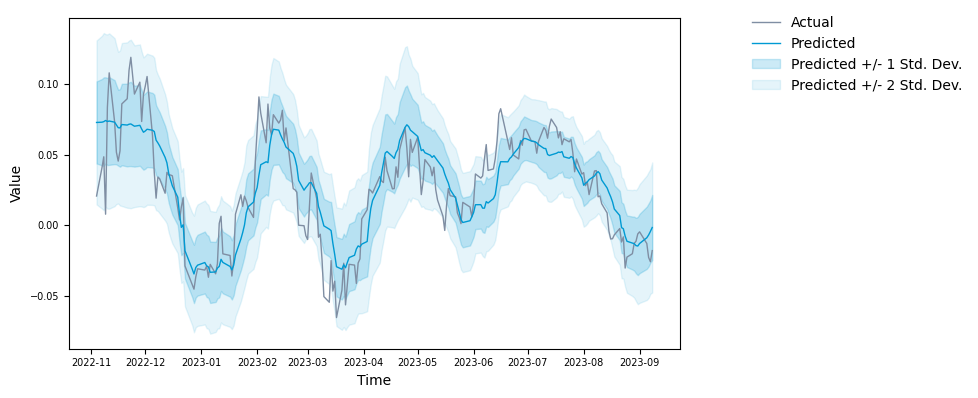

In [37]:
plot_predictions(training_predictions)

Generate the test set predictions.

In [38]:
test_predictions = get_predictions(test_dataset)

In [39]:
test_predictions.shape

(143, 3)

In [40]:
test_predictions.head()

,y_mean,y_std,y
2023-12-04,0.060522,0.019680,0.078645
2023-12-05,0.061875,0.019662,0.079763
2023-12-06,0.061947,0.019010,0.068609
2023-12-07,0.063818,0.019819,0.090989
2023-12-08,0.066188,0.020638,0.106979


In [41]:
test_predictions.tail()

,y_mean,y_std,y
2024-06-24,0.061514,0.013412,0.043862
2024-06-25,0.061969,0.013349,0.046140
2024-06-26,0.061515,0.013592,0.047952
2024-06-27,0.059986,0.013555,0.044033
2024-06-28,0.059339,0.013293,0.028293


Visualize the test set predictions.

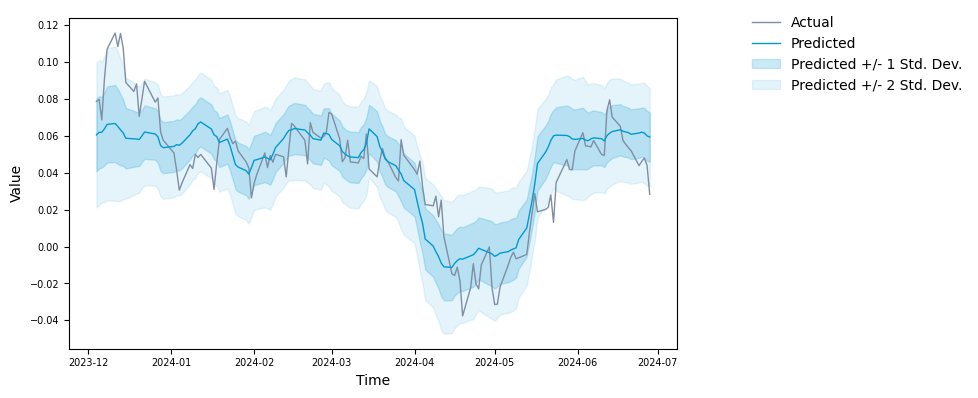

In [42]:
plot_predictions(test_predictions)

Calculate the model performance metrics.

In [43]:
metrics = pd.DataFrame({
    "Training": evaluate_predictions(training_predictions),
    "Test": evaluate_predictions(test_predictions)
})

In [44]:
metrics

,Training,Test
RMSE,0.020498,0.017852
MAE,0.016136,0.013938
Accuracy,0.905213,0.958042
F1,0.936709,0.975207


Generate the out of sample forecasts.

In [45]:
# extract the last 30 returns
payload = dataset.iloc[- context_length:]

# predict all rolling 30-day returns from day t to day t + 30
response = sagemaker_session.sagemaker_runtime_client.invoke_endpoint(
    EndpointName=predictor.endpoint_name,
    ContentType="text/csv",
    Body=payload.to_csv(index=False)
)
response = deserializer.deserialize(response["Body"], content_type="text/csv")

# add the dates from day t to day t + 30
forecasts = response.dropna()
forecasts.index = pd.date_range(start=dataset.index[-1] + pd.Timedelta(days=1), periods=prediction_length)

In [46]:
forecasts.shape

(30, 2)

In [47]:
forecasts.head()

,y_mean,y_std
2024-06-29,0.061482,0.014387
2024-06-30,0.049318,0.015124
2024-07-01,0.052732,0.015118
2024-07-02,0.056504,0.014320
2024-07-03,0.059297,0.013623


In [48]:
forecasts.tail()

,y_mean,y_std
2024-07-24,0.052545,0.011848
2024-07-25,0.054710,0.011290
2024-07-26,0.048143,0.012696
2024-07-27,0.040511,0.012385
2024-07-28,0.046622,0.013562


Visualize the out of sample forecasts.

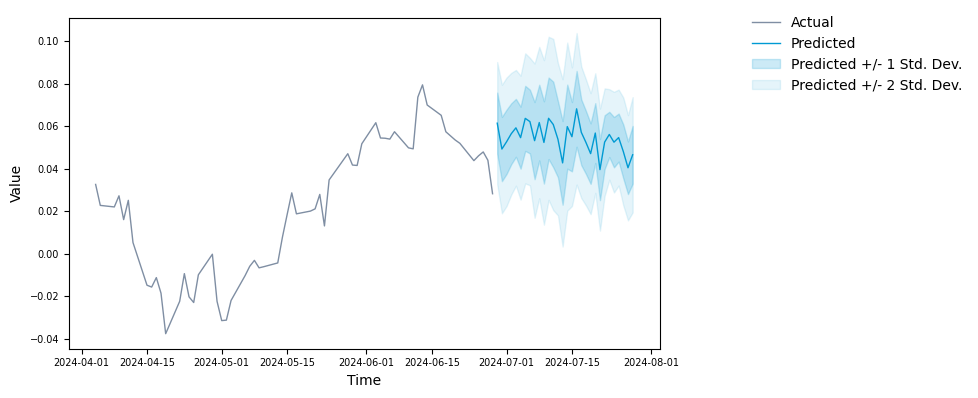

In [49]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(dataset.iloc[- context_length - prediction_length:].index, test_dataset["y"].iloc[- context_length - prediction_length:].values, color="#7f8ea3", lw=1, label="Actual")
ax.plot(forecasts.index, forecasts["y_mean"].values, color="#009ad3", lw=1, label="Predicted")
ax.fill_between(forecasts.index, forecasts["y_mean"].values + forecasts["y_std"].values, forecasts["y_mean"].values - forecasts["y_std"].values, color="#009ad3", alpha=0.2, lw=1, label="Predicted +/- 1 Std. Dev.")
ax.fill_between(forecasts.index, forecasts["y_mean"].values + 2 * forecasts["y_std"].values, forecasts["y_mean"].values - 2 * forecasts["y_std"].values, color="#009ad3", alpha=0.1, lw=1, label="Predicted +/- 2 Std. Dev.")
ax.set(xlabel="Time", ylabel="Value")
ax.xaxis.set_tick_params(labelbottom=True)
ax.tick_params(axis="both", which="major", labelsize=7)
ax.tick_params(axis="both", which="minor", labelsize=7)
fig.legend(bbox_to_anchor=(1, 0, 0.4, 1), frameon=False)
fig.tight_layout()
fig.show()

Delete the model.

In [50]:
predictor.delete_model()

INFO:sagemaker:Deleting model with name: cfc-tsf-v1-6-2024-06-29-19-39-21-270


Delete the endpoint.

In [51]:
predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: cfc-tsf-v1-6-2024-06-29-19-39-21-270
INFO:sagemaker:Deleting endpoint with name: cfc-tsf-v1-6-2024-06-29-19-39-21-270
